# Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2

import os

#EDA
import matplotlib.pyplot as plt
import plotly_express as px
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Label encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

#Data reading
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#CNN
from tensorflow.keras import layers, models, utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [12]:
main_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(main_dir, 'train')
valid_dir = os.path.join(main_dir, 'test')
test_dir = os.path.join(main_dir, 'val')

# Prepare folders directories

In [13]:
def folders(dir):
    penumonia = os.path.join(dir, 'PNEUMONIA')
    normal = os.path.join(dir, 'NORMAL')
    return normal, penumonia

In [14]:
normal_train, pneumonia_train = folders(train_dir)
normal_valid, pneumonia_valid = folders(test_dir)
normal_test,pneumonia_test = folders(valid_dir)

In [17]:
img_size = (224, 224)
batch_size = 16

train_data = image_dataset_from_directory(train_dir, image_size = img_size, batch_size = batch_size, shuffle = True)
valid_data = image_dataset_from_directory(valid_dir, image_size = img_size, batch_size = batch_size)
test_data = image_dataset_from_directory(test_dir, image_size = img_size, batch_size = batch_size)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [19]:
train_normal = len(os.listdir(normal_train))
train_pneumonia = len(os.listdir(pneumonia_train))

valid_normal = len(os.listdir(normal_valid))
valid_pneumonia = len(os.listdir(pneumonia_valid))

test_normal = len(os.listdir(normal_test))
test_pneumonia = len(os.listdir(pneumonia_test))

# Plot number of images in each directory

In [23]:
print("Number of NORMAL X-Rays in the train dataset =", train_normal)
print("Number of PNEUMONIA X-Rays in the train dataset =", train_pneumonia)
print("-"*60)

print("Number of NORMAL X-Rays in the valid dataset =", test_normal)
print("Number of PNEUMONIA X-Rays in the valid dataset =", test_pneumonia)
print("-"*60)

print("Number of NORMAL X-Rays in the test dataset =", valid_normal)
print("Number of PNEUMONIA X-Rays in the test dataset =", valid_pneumonia)
print("-"*60)


#Plot the nmber of images in each dataset
data = {'Train' : [train_pneumonia, train_normal],
       'Validation' : [test_pneumonia, test_normal],
       'Test' : [valid_pneumonia, valid_normal]}


df = pd.DataFrame(data, index = ['PNEUMONIA', 'NORMAL'])
fig = px.bar(df, x = data, color_discrete_sequence=["darkred", "darkblue", "darkgreen"])

fig.update_layout(title = 'Count of images in Train, Test and Validation sets',
                 xaxis_title = "Count",
                 yaxis_title = "X-Ray result",
                 height = 900, width = 900)
fig.show()

Number of NORMAL X-Rays in the train dataset = 1341
Number of PNEUMONIA X-Rays in the train dataset = 3875
------------------------------------------------------------
Number of NORMAL X-Rays in the valid dataset = 234
Number of PNEUMONIA X-Rays in the valid dataset = 390
------------------------------------------------------------
Number of NORMAL X-Rays in the test dataset = 8
Number of PNEUMONIA X-Rays in the test dataset = 8
------------------------------------------------------------


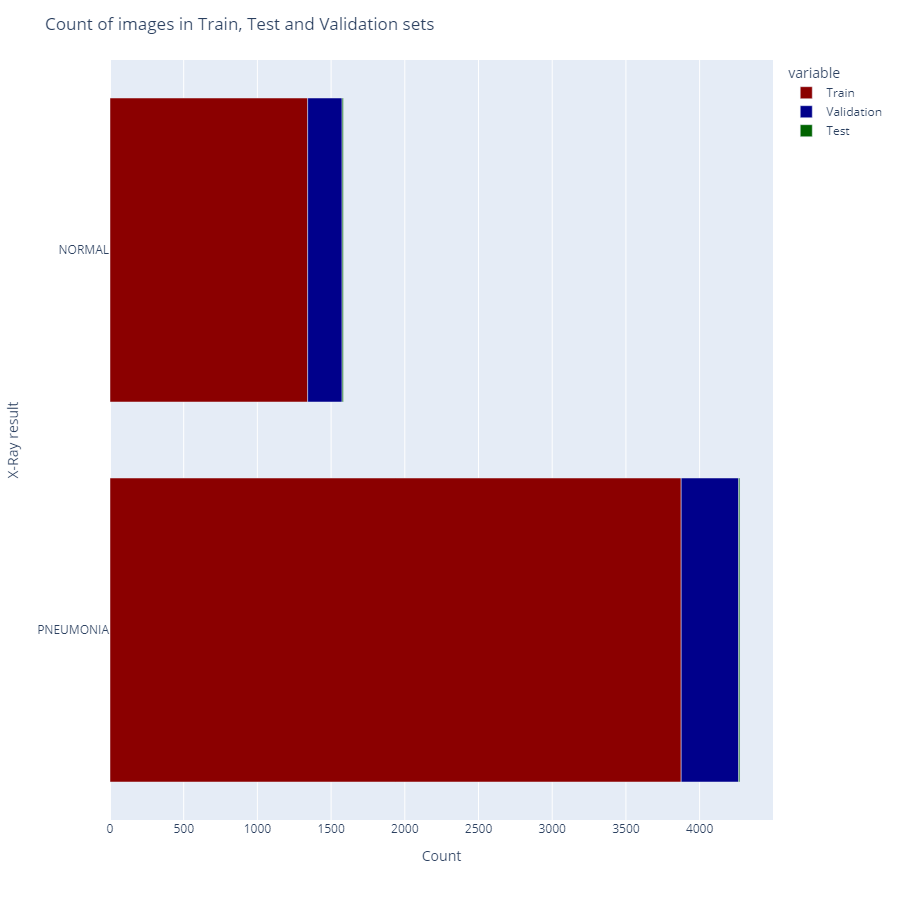

# Explore Dataset

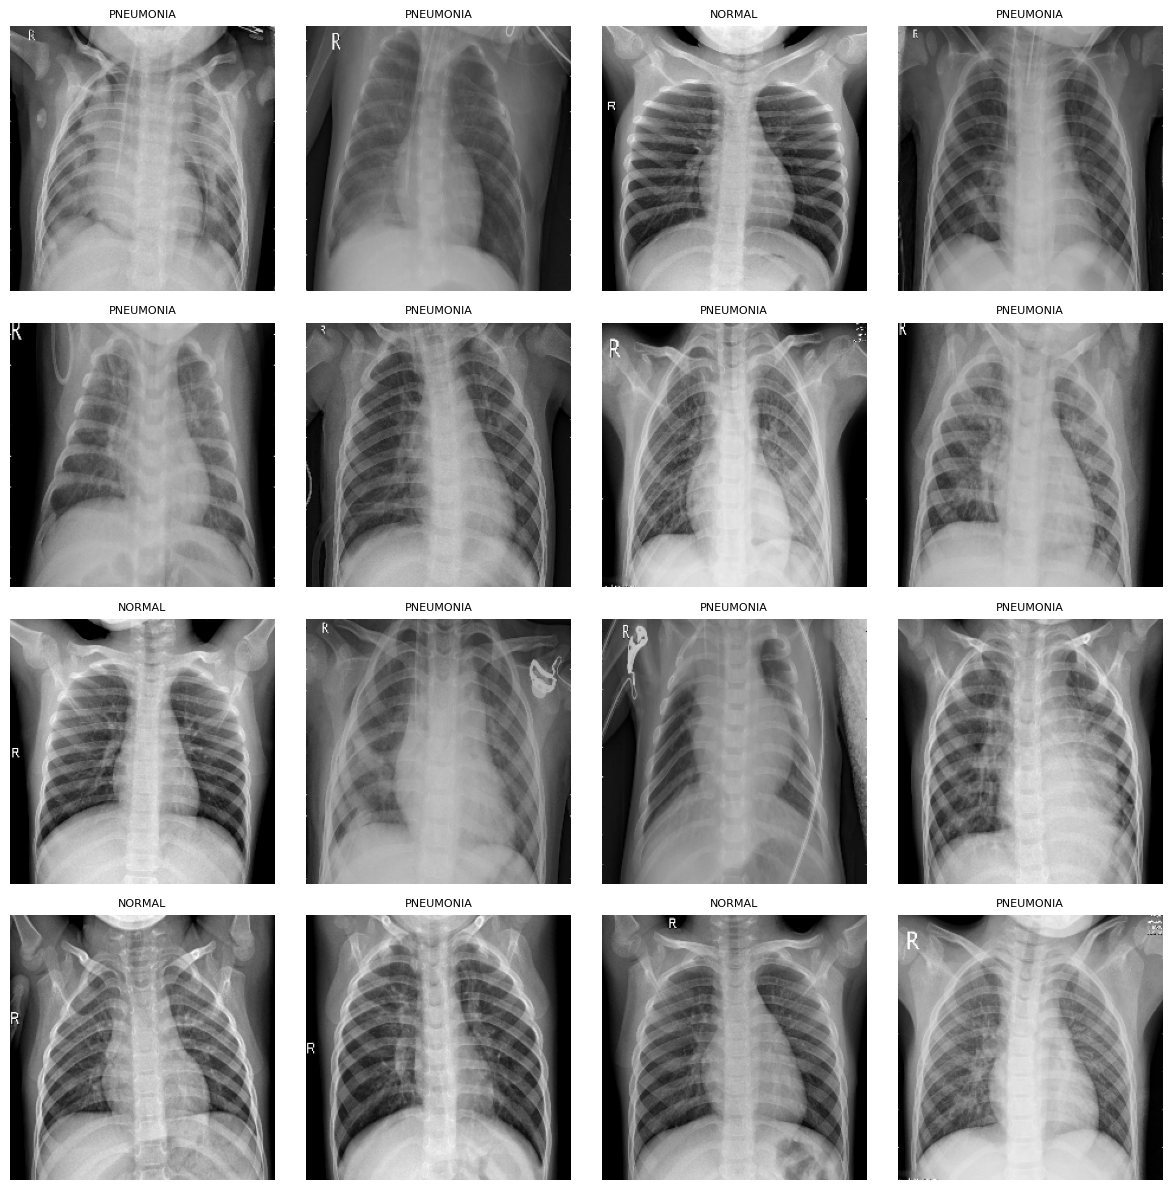

In [24]:
plt.figure(figsize=(12, 12))

for i ,(img, label) in enumerate(train_data):
    for n in range(16):
        plt.subplot(4, 4, n+1)
        plt.imshow(img[n].numpy().astype("uint8"))
        plt.title(train_data.class_names[label[n]], fontsize=8)
        plt.axis("off")
        
plt.tight_layout()
plt.show()

# Images Preprocessing

In [25]:
labels = ['NORMAL', 'PNEUMONIA']
def image_preprocessing(data_dir):
    img_list = []
    label_list = []
    
    for label in labels:
        class_dir = os.path.join(data_dir, label) #directory+label -> directory of the class
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name) #class directory + image name -> image name and its class
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) #read as grayscale
            img = cv2.resize(img, (225, 225))
            img = img / 255.0 #normalization
            img_list.append(img)
            label_list.append(label)
            
    return img_list, label_list

In [26]:
train_prep = image_preprocessing(train_dir)
valid_prep = image_preprocessing(valid_dir)
test_prep = image_preprocessing(test_dir)

In [27]:
#check for preprocessed images and labels
print("Number of preprocessed images =", len(train_prep[0]))
print("Number of preprocessed labels =", len(train_prep[1]))
print("-"*40)

print("Number of preprocessed images =", len(valid_prep[0]))
print("Number of preprocessed labels =", len(valid_prep[1]))
print("-"*40)

print("Number of preprocessed images =", len(test_prep[0]))
print("Number of preprocessed labels =", len(test_prep[1]))

Number of preprocessed images = 5216
Number of preprocessed labels = 5216
----------------------------------------
Number of preprocessed images = 624
Number of preprocessed labels = 624
----------------------------------------
Number of preprocessed images = 16
Number of preprocessed labels = 16


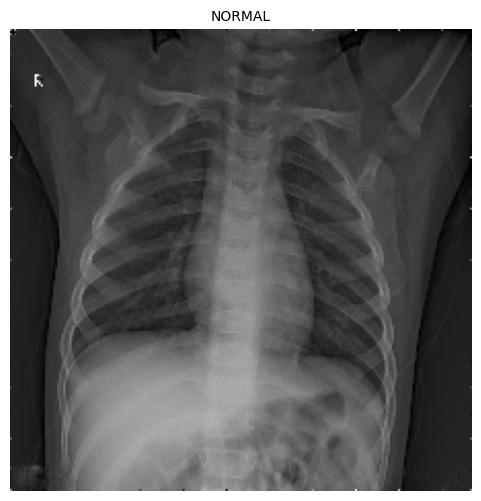

In [28]:
#plot first and last image to check labels are correct
plt.figure(figsize=(6, 6))
plt.imshow(train_prep[0][0], cmap = 'gray')
plt.title(train_prep[1][0], fontsize=10)
plt.axis("off")
plt.show()

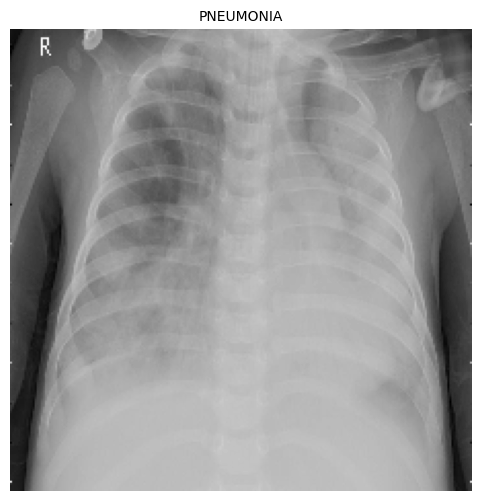

In [29]:
plt.figure(figsize=(6, 6))
plt.imshow(train_prep[0][-1], cmap = 'gray')
plt.title(train_prep[1][-1], fontsize=10)
plt.axis("off")
plt.show()

# Prepare data for training

In [30]:
#convert images to numpy array and reshape them for training
train_imgs = np.array(train_prep[0]).reshape(-1, 225, 225, 1)
valid_imgs = np.array(valid_prep[0]).reshape(-1, 225, 225, 1)
test_imgs = np.array(test_prep[0]).reshape(-1, 225, 225, 1) 

In [31]:
#label encoding
enc = LabelEncoder()

train_enc = enc.fit_transform(train_prep[1])
valid_enc = enc.fit_transform(valid_prep[1])
test_enc = enc.fit_transform(test_prep[1])

In [32]:
#one-hot encoding
train_labels = to_categorical(train_enc, num_classes=2)
valid_labels = to_categorical(valid_enc, num_classes=2)
test_labels = to_categorical(test_enc, num_classes=2)

# Build Model

In [69]:
input_shape = (224, 224, 1)
model = Sequential()

#conv b1
model.add(Conv2D(32, kernel_size=(3, 3), strides=1, padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), strides=1, padding='same'))
#model.add(Conv2D(32, kernel_size=(3, 3), strides=1, padding='same'))
model.add(MaxPool2D(2, 2)) #reduces to 112x112

#conv b2
model.add(Conv2D(64, kernel_size=(3, 3), strides=1, padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), strides=1, padding='same'))
#model.add(Conv2D(64, kernel_size=(3, 3), strides=1, padding='same'))
model.add(MaxPool2D(2, 2)) #reduces to 56x56

#conv b3
model.add(Conv2D(128, kernel_size=(3, 3), strides=1, padding='same'))
model.add(Conv2D(128, kernel_size=(3, 3), strides=1, padding='same'))
#model.add(Conv2D(128, kernel_size=(3, 3), strides=1, padding='same'))
model.add(MaxPool2D(2, 2)) #reduces to 28x28
model.add(BatchNormalization())

#conv b4
model.add(Conv2D(256, kernel_size=(3, 3), strides=1, padding='same'))
model.add(Conv2D(256, kernel_size=(3, 3), strides=1, padding='same'))
#model.add(Conv2D(256, kernel_size=(3, 3), strides=1, padding='same'))
model.add(MaxPool2D(2, 2)) #reduces to 14x14
model.add(BatchNormalization())

model.add(Conv2D(256, kernel_size=(3, 3), strides=1, padding='same'))
model.add(Conv2D(256, kernel_size=(3, 3), strides=1, padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2)) #reduces to 7x7

model.add(Conv2D(512, kernel_size=(3, 3), strides=1, padding='same'))
model.add(Conv2D(512, kernel_size=(3, 3), strides=1, padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2)) #reduces to 7x7

model.add(Flatten())

#model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_81 (Conv2D)              │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_92 (Conv2D)              │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 4608)           │             

 Total params: 6,496,898 (24.78 MB)

 Trainable params: 6,494,530 (24.77 MB)

 Non-trainable params: 2,368 (9.25 KB)

# Parameters & Compiling

In [70]:
lr = 1e-3
epochs = 20
batch_size = 16
history = model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.losses.BinaryCrossentropy,
              metrics=['accuracy'])

In [71]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=2, min_lr=1e-7)

# Model Training

In [72]:
history = model.fit(train_imgs, train_labels, validation_data=(valid_imgs, valid_labels), epochs = epochs
                   ,callbacks = [early_stopping, reduce_lr])

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 157ms/step - accuracy: 0.8525 - loss: 0.4161 - val_accuracy: 0.7548 - val_loss: 0.5341 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - accuracy: 0.9541 - loss: 0.1425 - val_accuracy: 0.8798 - val_loss: 0.5199 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 158ms/step - accuracy: 0.9676 - loss: 0.0950 - val_accuracy: 0.8301 - val_loss: 0.5195 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 166ms/step - accuracy: 0.9705 - loss: 0.0753 - val_accuracy: 0.8734 - val_loss: 0.4962 - learning_rate: 0.0010
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 163ms/step - accuracy: 0.9735 - loss: 0.0731 - val_accuracy: 0.8590 - val_loss: 0.4409 - learning_rate: 0.0010
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 161ms/step - accuracy: 0.9724 - loss: 0.0718 - val_accuracy: 0.7420 - val_loss: 1.0622 - learning_rate: 0.0010
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - accuracy: 0.9

# Model Evaluation

In [73]:
loss, acc = model.evaluate(valid_imgs, valid_labels)
print("Validation Loss = ", loss)
print("Validation Accuracy = ", acc*100, "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7568 - loss: 0.8498
Validation Loss =  0.5240562558174133
Validation Accuracy =  85.25640964508057 %


In [74]:
loss, acc = model.evaluate(test_imgs, test_labels)
print("Test Loss = ", loss)
print("Test Accuracy = ", acc*100, "%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0822
Test Loss =  0.08217252790927887
Test Accuracy =  100.0 %


# Learning Curve

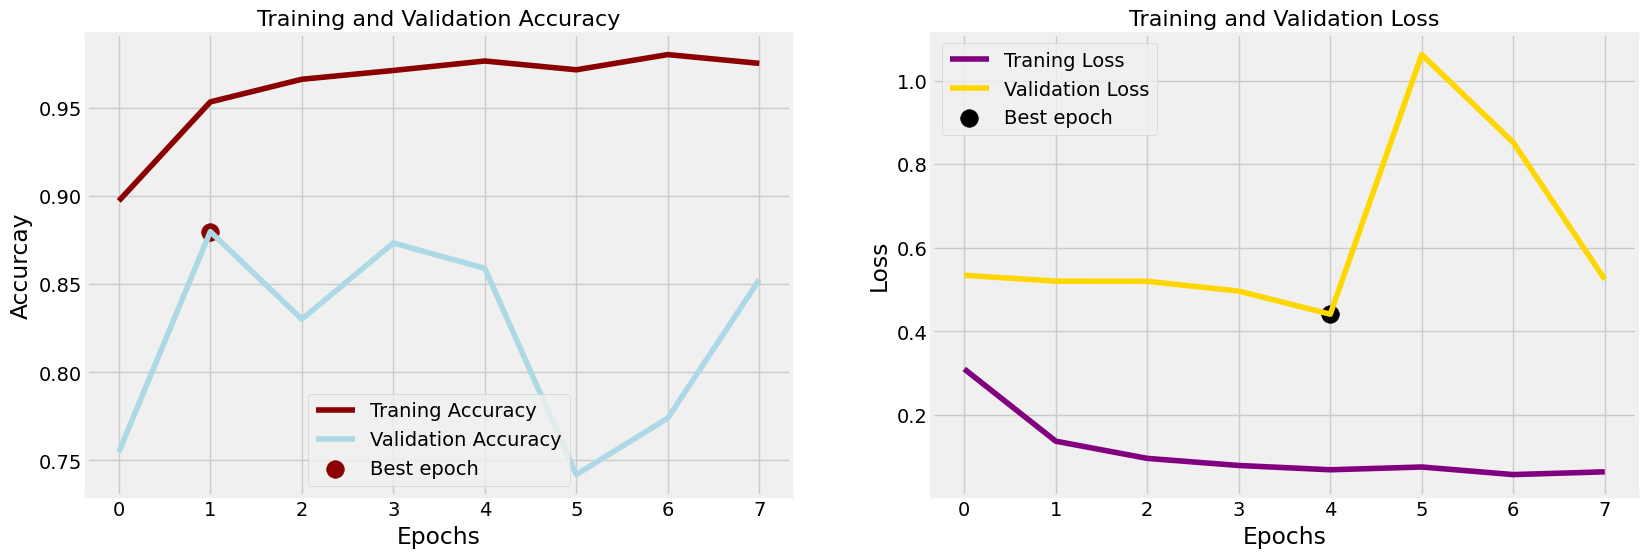

In [75]:
#train history
train_acc = history.history['accuracy']
train_loss = history.history['loss']

#validatioin history
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

min_loss = np.argmin(val_loss) # get min val loss epoch #
val_lowest = val_loss[min_loss]

max_acc = np.argmax(val_acc) #get max val acc epoch #
val_max = val_acc[max_acc]

epochs_ = [i for i in range(len(train_acc))]

#Plot Style
plt.figure(figsize = (20,6))
plt.style.use('fivethirtyeight')

#Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_, train_acc, 'darkred', label = "Traning Accuracy")
plt.plot(epochs_, val_acc, 'lightblue', label = "Validation Accuracy")
plt.scatter(max_acc, val_max, s = 160, c = "darkred", label = "Best epoch")

plt.title("Training and Validation Accuracy", fontsize = 16)
plt.xlabel("Epochs")
plt.ylabel("Accurcay")
plt.legend()

#Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_, train_loss, 'purple', label = "Traning Loss")
plt.plot(epochs_, val_loss, 'gold', label = "Validation Loss")
plt.scatter(min_loss, val_lowest, s = 160, c = "black", label = "Best epoch")

plt.title("Training and Validation Loss", fontsize = 16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Model Scores

In [76]:
preds = model.predict(test_imgs)
label_preds = np.argmax(preds, axis = 1)
true_labels = np.argmax(test_labels, axis = 1)
cr = classification_report(true_labels, label_preds, target_names=['NORMAL', 'PNEUMONIA'])
print(cr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00         8
   PNEUMONIA       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



# Confusion Matrix

<Figure size 1000x1000 with 0 Axes>

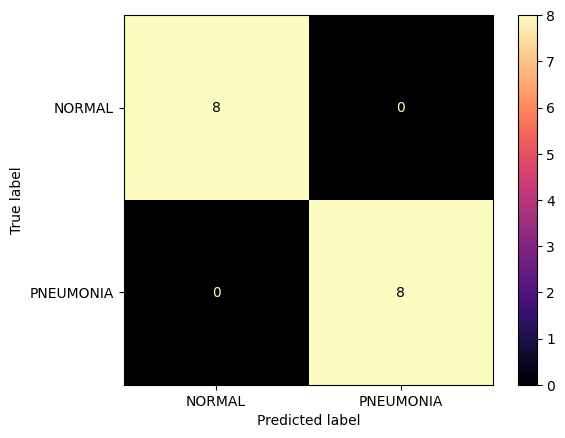

In [77]:
plt.style.use('default')
cm = confusion_matrix(true_labels, label_preds)
disp_cm = ConfusionMatrixDisplay(cm, display_labels=labels)
plt.figure(figsize=(10, 10))
disp_cm.plot(cmap='magma')
plt.show()

- The original data distribution had more images in the test dataset than in the validation dataset which led to the model not having the best `Precision` and `Recall` scores, which also could lead to fatal mistakes in the medical field

- In this notebook, the **validation** and **test** datasets were switched so the validation dataset is a bit bigger which is more realistic. As a result the model achieved a `100%` Test Accuracy, `Precision` and `Recall` scores

- These scores are only **theoritical** and are hard to achieve practically, but due to the mishandling of data distribution the model could reach `100%` scores